In [ ]:
# default_exp funcs.dataset

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Dataset and transformations

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from typing import Union
import skimage.measure
from torch.utils.data import DataLoader
import random
import inspect
from scipy.ndimage import gaussian_filter
from perlin_numpy import generate_fractal_noise_3d, generate_perlin_noise_3d
from torch.nn import functional as F
import numbers

In [ ]:
#export
class DecodeDataset:
    
    def __init__(self, volumes: list,
                 dataset_tfms: list, 
                 rate_tfms: list, 
                 bg_tfms: list, 
                 num_iter: int = 5000, 
                 from_records: bool = True,
                 device: str = 'cpu'):
        """
        Basic Dataset

        Args:
            path (str): [image_path]
            dataset_tfms (list): transformation specific to dataset
            rate_tfms ([type]): transformation for rate generation
            bg_transform ([type]): background transformation
            num_iter (int, optional):define lenth of dataset. Defaults to 5000.
            device (str, optional): device cpu or gpu]. Defaults to 'cpu'.
        """
        
        self.volumes = volumes
        self.dataset_tfms = dataset_tfms
        self.num_iter = num_iter
        self.rate_tfms = rate_tfms
        self.bg_tfms = bg_tfms
        self.device = device
        self.from_records = from_records
        
        print(f'{len(self.volumes)} volumes')
        
    def __len__(self):
        return self.num_iter

    def __getitem__(self, _):
        
        ret_dict = {}
        
        i = random.randint(0,len(self.volumes)-1)
        x = self.volumes[i] # Adding dimension here to get to 4.
        x = self._compose(x, self.dataset_tfms, ind = i).to(self.device)
        local_rate = self._compose(x, self.rate_tfms, ind = i)
        background = self._compose(x, self.bg_tfms)
        
#         print(self.dataset_tfms[0].slice_h_glob, self.dataset_tfms[0].slice_w_glob, self.dataset_tfms[0].slice_d_glob)
        ret_dict['x'] = x
        ret_dict['local_rate'] = local_rate
        ret_dict['background'] = background
        ret_dict['frame_idx'] = i
        if self.from_records:
            ret_dict['crop_z'] = self.dataset_tfms[0].slice_z_glob
            ret_dict['crop_y'] = self.dataset_tfms[0].slice_y_glob
            ret_dict['crop_x'] = self.dataset_tfms[0].slice_x_glob

        return ret_dict
    
#         return x, local_rate, background, self.dataset_tfms[0].slice_h_glob, self.dataset_tfms[0].slice_w_glob, self.dataset_tfms[0].slice_d_glob
#         return x.to(self.device), local_rate.to(self.device), background.to(self.device)
    
    def __repr__(self):
        print (f'{self.__class__.__name__} Summary:')
        print (f'Dataset tfms: {len(self.dataset_tfms)}')
        for i in self.dataset_tfms:
            print (f'\n-->')
            f"{i}"
        return ''
    
    @staticmethod
    def _compose(x, list_func, **kwargs):
#         if not list_func: list_func.append(lambda x: x)
        if not list_func: 
            return x
        for func in list_func:
            x = func(x, **kwargs)
        return x

In [ ]:
#export
def print_class_signature(self, nms):
    "print class signature"
    mod = inspect.currentframe().f_back.f_locals
    for n in nms:
        print(f'{n}: {getattr(self,n)}')
#export
class TransformBase:
    '''
    All transformations optionally must be inherited from this class for nice
    representations and checks if input to given transformations is a tensor

    '''
    def __repr__(self):
        print (f'Transform({self.__class__.__name__})')
        name = inspect.signature(self.__class__).parameters.keys()
        print_class_signature(self, name)
        return ''

    def __call__(self, x, **kwargs):
        assert isinstance(x, torch.Tensor), f'must be torch.tensor not {type(x)}'

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')

In [ ]:
#export
class ScaleTensor(TransformBase):
    """
    \nScales given `torch.Tensor` between `low` and `high`

    \nParameters:
    \n`low`     : lower bound
    \n`high`    : upper bound
    \n`data_min`: max value of data
    \n`data_max`: min value of main data

    \nReturns:
    \nScaled tensor

    """
    def __init__(self, low: float=0., high: float=1.):
        self.low = low
        self.high = high

    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        ratio = (self.high-self.low) / (x.max()-x.min() + 1)
        return ratio * (x - x.min() + 1) + self.low
    
class RandScale(TransformBase):

    def __init__(self, low: float, high: float):
        self.low = low
        self.high = high

    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        ratio = torch.distributions.Uniform(self.low, self.high).sample()
        return ratio * x
    
class UniformValue(TransformBase):
    def __init__(self, min_val=0., max_val=0., img_mean=False, sep_channels=False):
        self.min_val = min_val
        self.max_val = max_val
        self.sep_channels = sep_channels
        self.img_mean = img_mean
    
    def __call__(self, image, **kwargs):
        if self.sep_channels:
            if self.img_mean:
                rand_val = image.mean(-1).mean(-1).mean(-1)
            else:
                rand_val = torch.distributions.Uniform(self.min_val, self.max_val).sample([len(image)]).to(image.device)
            return torch.ones_like(image)*rand_val[:,None,None,None]            
        else:
            if self.img_mean:
                rand_val = image.mean()
            else:
                rand_val = torch.distributions.Uniform(self.min_val, self.max_val).sample([1]).to(image.device)
            return torch.ones_like(image[:1])*rand_val
    
def get_forward_scaling(img):
    
    offset = np.median(img)
    scale = np.max(np.array(img))/5
#     offset = np.median(np.array(img), axis=(1,2,3))
#     scale = np.max(np.array(img), axis=(1,2,3))/3
    return offset, scale

In [ ]:
#export
class RandomCrop3D(TransformBase):
    """
    Ramdomly Crops 3D tensor.

    \nThis class will generate random crop of `crop_sz`. This class is initialized
    with `img_sz` which should be a demension of 4 [Channel, Height, Width, Depth] and
    a `crop_sz` dimesnion of 3 [Height, Width, Depth] of desired crop. For each crop
    dimension `_get_slice` function will calculate random int ranging from 0 to (img_sz-crop_sz).
    and return tuple of containing two slice intergers. If one dimension of `img_sz` matches
    one dimension of `crop_sz` the resulting tuple will be `(None, None)` which will result
    in not croping this particular dimension.


    \nParameters:
    \n`crop_sz`    : Size of the 3D crop  `(H, W, D)`

    \nReturns:
    \nCroped 3D image of the given `crop_sz`

    """
    def __init__(self, crop_sz, roi_masks):
        assert len(crop_sz) == 3 , f'Lenth of crop_sz should be 3 not {len(crop_sz)}'
        self.crop_sz = tuple(crop_sz)
        self.crop_prod = crop_sz[0]*crop_sz[1]*crop_sz[2]
        self.roi_masks = roi_masks
        
        self.slice_z_glob = 0
        self.slice_y_glob = 0
        self.slice_x_glob = 0

    def __call__(self, x, **kwargs):
        ch, d, h, w = x.shape
        img_sz  = tuple((d, h, w))
        assert (img_sz) >=  self.crop_sz
        super().__call__(x, **kwargs)
        slice_zyx = [self._get_slice(i, k) for i, k in zip(img_sz, self.crop_sz)]
        if 'ind' in kwargs:
            while self._crop(self.roi_masks[kwargs['ind']][None], *slice_zyx).sum()/self.crop_prod < 0.5:
                slice_zyx = [self._get_slice(i, k) for i, k in zip(img_sz, self.crop_sz)]
                
        self.slice_z_glob = slice_zyx[0][0] if slice_zyx[0][0] is not None else 0
        self.slice_y_glob = slice_zyx[1][0]
        self.slice_x_glob = slice_zyx[2][0]
                
        return self._crop(x, *slice_zyx)


    @staticmethod
    def _get_slice(sz, crop_sz):
        up_bound = sz-crop_sz
        if  up_bound == 0:
            return None, None
        else:
            l_bound = torch.randint(up_bound, (1,))
        return l_bound, l_bound + crop_sz

    @staticmethod
    def _crop(x, slice_h, slice_w, slice_d):
        return x[:, slice_h[0]:slice_h[1], slice_w[0]:slice_w[1], slice_d[0]:slice_d[1]]

In [ ]:
#export
class AddFoci(TransformBase):
    
    def __init__(self, n_foci_avg: float, rad_range: tuple, n_mol_range: tuple, px_size_zyx: tuple=(100,100,100), mode='gaussian'):
        
        self.n_foci_avg = n_foci_avg
        self.rad_range = rad_range
        self.n_mol_range = n_mol_range
        self.px_size_zyx = px_size_zyx
        self.mode = mode
        
    def binary_sphere(self, shape, radius, position):
        grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
        position = np.ogrid[grid]
        arr = np.zeros(shape, dtype=float)
        for x_i, semisize in zip(position, radius):
            arr += (x_i / semisize) ** 2

        return arr <= 1.0
    
    def gaussian_sphere(self, shape, radius, position):
        grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
        position = np.ogrid[grid]
        arr = np.exp(-position[0]**2 / (2 * (radius[0] ** 2))) * np.exp(-position[1]**2 / (2 * (radius[1] ** 2))) * np.exp(-position[2]**2 / (2 * (radius[2] ** 2))) / (2 * np.pi * (radius[0] * radius[1] * radius[2]))
        return arr
    
    def __call__(self, x, **kwargs) -> torch.Tensor:
        super().__call__(x)
        
        prob = self.n_foci_avg/torch.numel(x[0])
        locations = torch.distributions.Bernoulli(torch.ones_like(x)*prob).sample()
        xwf = x + 0
        
        for inds in torch.nonzero(locations, as_tuple=False):
            rad = torch.distributions.Uniform(*self.rad_range).sample().item()
            rads = [rad/pxs for pxs in self.px_size_zyx]
            n_mol = torch.distributions.Uniform(*self.n_mol_range).sample().item()
            center = inds[-3:].cpu().numpy()
            size = list(x.shape[-3:])
            if 'gaus' in self.mode:
                foci = torch.tensor(self.gaussian_sphere(list(x.shape[-3:]), rads, center))
            if 'bin' in self.mode:
                foci = torch.tensor(self.binary_sphere(list(x.shape[-3:]), rads, center))
            foci = foci * (n_mol / foci.sum())
            xwf[inds[0]] += foci.to(x.device)
        
        return xwf

In [ ]:
# export
class torch_gaussian_filter(torch.nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self,  kernel_size, sigma, dim=2):
        super(torch_gaussian_filter, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        self.kernel_size = kernel_size
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(1, *[1] * (kernel.dim() - 1))

        self.conv = torch.nn.Conv3d(1, 1, kernel_size=kernel_size, padding=[k//2 for k in kernel_size], padding_mode='replicate', bias=0)
        self.conv.weight = torch.nn.Parameter(kernel)

    def forward(self, x):
        """
        Apply gaussian filter to input.
        Arguments:
            x (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        with torch.no_grad():
            shape = x.shape
            out = self.conv(x.reshape(-1,1,*shape[-3:])).reshape(shape)
        return out

In [ ]:
# export
def get_uneven(x):
    return int(2*np.ceil(x/2)-1)

class GaussianSmoothing(TransformBase):
    def __init__(self, smoothing_filter_size, div_factor=1, device='cuda', z_size=48):
        self.smoothing_filter_size = smoothing_filter_size
        self.div_factor = div_factor
        ''' FIX KERNEL SIZE'''
        self.gaussian_filter = torch_gaussian_filter(kernel_size=[get_uneven(np.min([z_size, smoothing_filter_size])), 
                                                                                             smoothing_filter_size*2-1, 
                                                                                             smoothing_filter_size*2-1], 
                                                     sigma=smoothing_filter_size, dim=3).to(device)
    
    def __call__(self, image, **kwargs):
        background = self.gaussian_filter(image[None])/self.div_factor
        # Scipy version, to slow
        # background = gaussian_filter(image, self.smoothing_filter_size)/self.div_factor  
        # background.clamp_min_(1.)
        return background[0]
    
class AddPerlinNoise(TransformBase):
    def __init__(self, shape, res, octaves, scale=1, persistence=0.5, lacunarity=2):
        
        self.shape = shape
        self.res = res
        self.scale = scale
        self.octaves = octaves
        self.persistence = persistence
        self.lacunarity = lacunarity
    
    def __call__(self, image, **kwargs):
        
        assert all(i <= self.shape for i in image.shape[-3:])
        
        res = self.res
        bs_x_ch = image.shape[0] * image.shape[1]
        
        color_chs = torch.tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]).to(image.device)
        
        if image.shape[-3] > 1:        
            fractal_noise = [generate_fractal_noise_3d_torch([self.shape,self.shape,self.shape], res, self.octaves, self.persistence, device=image.device) for _ in range(bs_x_ch)]
            fractal_noise = torch.stack(fractal_noise)
            fractal_noise = fractal_noise[:,:image.shape[-3],:image.shape[-2],:image.shape[-1]]
        
        else:
            fractal_noise = [generate_fractal_noise_2d_torch([self.shape,self.shape], res, self.octaves, self.persistence, device=image.device) for _ in range(bs_x_ch)]
            fractal_noise = torch.stack(fractal_noise)
            fractal_noise = fractal_noise[:,:image.shape[-2],:image.shape[-1]]
        
        # Hardcoded MOp color channels
        fractal_noise = fractal_noise.reshape(image.shape) * color_chs[:,None,None,None]
        
        return image + self.scale*fractal_noise
        

In [ ]:
%%timeit
noise = generate_fractal_noise_2d((56, 56), (28, 28))

NameError: name 'generate_fractal_noise_2d' is not defined

In [ ]:
%%timeit
noise = generate_fractal_noise_2d_torch((56, 56), (28, 28), device='cuda')

1.7 ms ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
#export
def get_roi_mask(img, pool_size=(10,10,10), percentile=50):
    img = img.mean(0)
    mp_img = skimage.measure.block_reduce(img, pool_size, np.max)
    thresh = np.percentile(mp_img,percentile)
    mp_img = np.where(mp_img>thresh,1,0)
    mp_img = np.kron(mp_img, np.ones((pool_size), dtype=mp_img.dtype))
    mp_img = mp_img[:img.shape[0], :img.shape[1], :img.shape[2]] 
    return mp_img

In [ ]:
from decode_fish.funcs.file_io import load_psf_noise_micro
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.plotting import *

In [ ]:
pfile = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/mRNAlevel_500/random/NR/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_10__random__1.tif'
pdir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/mRNAlevel_500/random/NR/w1*.tif'
pdir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_500/foci/strong/w1*.tif'
pdir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

In [ ]:
imgs_5d        = torch.cat([load_tiff_image(f) for f in glob.glob(pdir)])[None]
smoothing      = GaussianSmoothing(smoothing_filter_size=5, div_factor=1, z_size=1)
roi_masks      = [get_roi_mask(img, pool_size=(10,10,10), percentile=70) for img in imgs_5d]
rand_crop      = RandomCrop3D((1,48,48), roi_masks)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [ ]:
probmap_generator = UniformValue(0.0001, 0.0005)

focifier = AddFoci(n_foci_avg=5, 
                   rad_range=(100,500), 
                   n_mol_range=(5.,30.), 
                   px_size_zyx =(100,100,100),
                   mode='bin')

fractal_noise = AddPerlinNoise(48, [24,24], 2, scale=50)

In [ ]:
ds = DecodeDataset(volumes = imgs_5d,
                   dataset_tfms =  [rand_crop], 
                   rate_tfms = [probmap_generator, focifier], 
                   bg_tfms = [smoothing], 
                   device='cuda:0', 
                   num_iter=100 * 4) 

1 volumes


In [ ]:
decode_dl = DataLoader(ds, batch_size=5, num_workers=0)

In [ ]:
for i in range(5):
#     x, local_rate, background, z, y, x = next(iter(decode_dl))
    ret_dict = next(iter(decode_dl))
    print(ret_dict['local_rate'].sum(-1).sum(-1))
#     print(y)
#     print(x.mean())

tensor([[[42.8297]],

        [[92.1307]],

        [[26.3713]],

        [[87.4520]],

        [[41.4306]]], device='cuda:0')
tensor([[[ 49.2789]],

        [[112.7144]],

        [[  8.1010]],

        [[ 36.1120]],

        [[136.2739]]], device='cuda:0')
tensor([[[127.1305]],

        [[ 40.5988]],

        [[168.6736]],

        [[ 71.6909]],

        [[115.5068]]], device='cuda:0')
tensor([[[ 63.6501]],

        [[ 72.1316]],

        [[ 77.6524]],

        [[ 48.0099]],

        [[102.9800]]], device='cuda:0')
tensor([[[120.9879]],

        [[ 64.9929]],

        [[116.8398]],

        [[111.4217]],

        [[ 86.6281]]], device='cuda:0')


In [ ]:
ret_dict['crop_z']

tensor([0, 0, 0, 0, 0])

In [ ]:
# plot_3d_projections(generate_fractal_noise_3d(shape=(48,48,48), res=(3,6,6), octaves=3, tileable=(False, False, False), persistence=.75, lacunarity=2))

(<Figure size 484.2x441 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

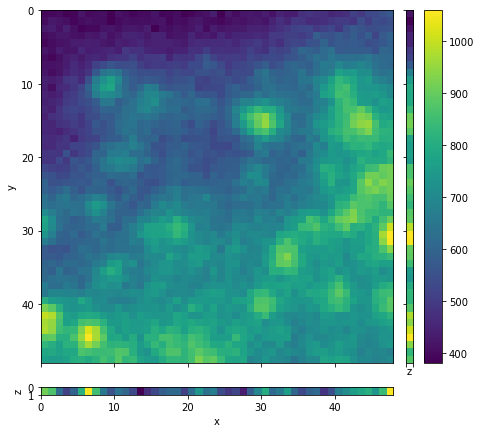

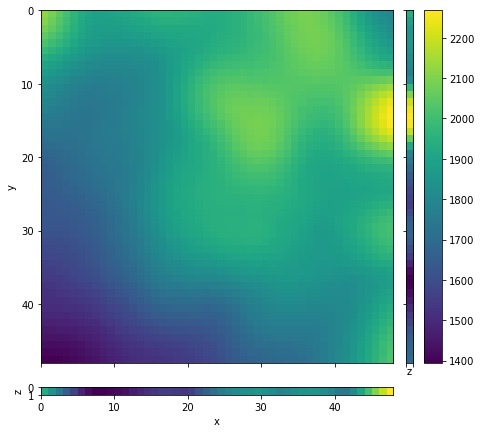

In [ ]:
# x, local_rate, background = next(iter(decode_dl))
plot_3d_projections(x[1,0], proj_func=np.max)
plot_3d_projections(background[0,6], proj_func=np.max)
# plot_3d_projections(x[0,0])

In [ ]:
from noise import snoise2

In [ ]:
from decode_fish.funcs.exp_specific import read_MOp_tiff, get_mop_colors
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', z_to_batch=True, scaled=True)

In [ ]:
img_stack.shape
col_chs = get_mop_colors()[:22]

In [ ]:
img_stack[:,col_chs.nonzero()[0]]

torch.Size([7, 11, 1, 500, 500])

In [ ]:
img_stack = img_stack[:,:,:,1250:1750,750:1250]

In [ ]:
img_stack[:,col_chs.nonzero()[1]].shape

IndexError: tuple index out of range

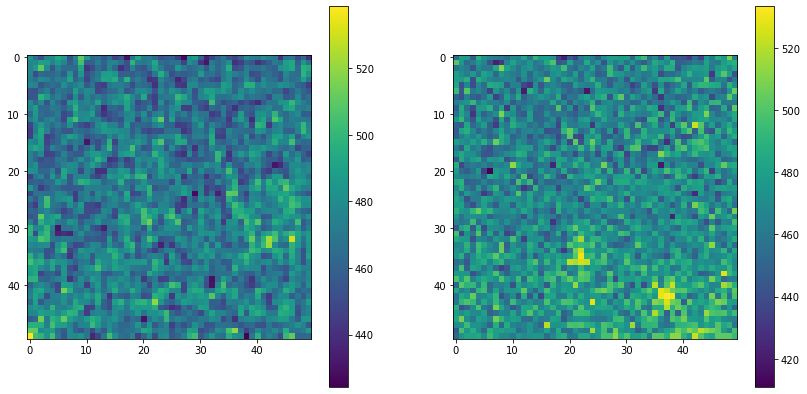

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(cpu(img_stack[:,col_chs.nonzero()[0]])[5,0,0,175:225,250:300])
plt.colorbar()
plt.subplot(122)
plt.imshow(cpu(img_stack[:,np.where(col_chs==0)[0]])[5,0,0,175:225,250:300])
plt.colorbar()

In [ ]:
from scipy import signal

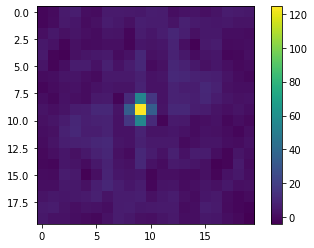

In [ ]:
img = cpu(img_stack[:,col_chs.nonzero()[0]])[5,0,0,175:225,250:300]
img = img - img.mean()
img = img/img.max()
auto = scipy.signal.correlate2d(img,img)
plt.imshow(auto[40:60,40:60])
plt.colorbar()

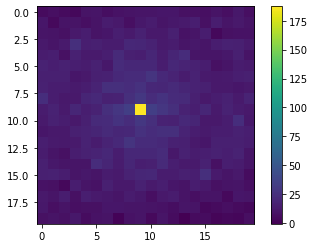

In [ ]:
img = cpu(img_stack[:,np.where(col_chs==0)[0]])[5,0,0,175:225,250:300]
img = img - img.mean()
img = img/img.max()
auto = scipy.signal.correlate2d(img,img)
plt.imshow(auto[40:60,40:60])
plt.colorbar()

In [ ]:
# Use simplex noise?

In [ ]:
noise2 = snoise2(48, 48, octaves=1, persistence=0.5, lacunarity=2.0, repeatx=1, repeaty=1, base=0.0)

NameError: name 'snoise2' is not defined

In [ ]:
from perlin_numpy import generate_fractal_noise_2d, generate_perlin_noise_3d

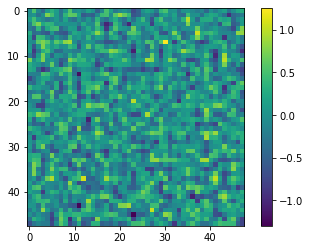

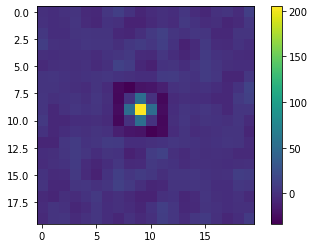

In [ ]:
# %%timeit
noise = generate_fractal_noise_2d((48, 48), (24, 24), 1, persistence=.5, lacunarity=2, tileable=(False, False))
noise += np.random.randn(48,48)*0.2
plt.imshow(noise)
plt.colorbar()
plt.show()
img = noise
img = img - img.mean()
img = img/img.max()
auto = scipy.signal.correlate2d(img,img)
plt.imshow(auto[38:58,38:58])
plt.colorbar()

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
